<a href="https://colab.research.google.com/github/megcp/Research-project-sentiment-driven-stock-market-prediction/blob/main/RP7_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing dependencies
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock = pd.read_csv('/content/drive/My Drive/Research Project/apple_dataframe_ready_for_ML_3.csv')

In [ ]:
# convert date into datetime
stock['Date'] = pd.to_datetime(stock['Date'])

# set date as index
stock.set_index('Date', inplace=True)
# Shift the target variable back a day so that we are using today's information to predict tomorrow's movement
stock['movement (shifted -1)'] = stock['movement'].shift(-1)

# dropping na rows created from shifting movement
stock.dropna(inplace=True)

# dropping 'movement' column
stock.drop(columns=['movement'], inplace=True)

# splitting the data - maintaining chronological order as it is time-series data
split_ratio = 0.7
split_point = int(len(stock) * split_ratio)

train = stock.iloc[:split_point]
test = stock.iloc[split_point:]

# seperate features and target
X_train = train.drop(columns=['movement (shifted -1)'])
y_train = train['movement (shifted -1)']
X_test = test.drop(columns=['movement (shifted -1)'])
y_test = test['movement (shifted -1)']

In [ ]:
# scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# extract the feature names - to be used later
feature_names = X_train.columns

Best k:  8
Selected Features:  Index(['Average Sentiment Score', 'high', 'change', 'daily variation', 'MACD',
       'sentiment 14D shift', 'Sentiment 5D Rolling Avg',
       'enocded sentiment 7D shift'],
      dtype='object')
Best Test Accuracy:  0.5576923076923077
Train Accuracy:  0.6602209944751382
Test Accuracy (after final fit):  0.4807692307692308

Classification Report on Test Set:
              precision    recall  f1-score   support

        -1.0       0.46      0.50      0.48        74
         1.0       0.51      0.46      0.48        82

    accuracy                           0.48       156
   macro avg       0.48      0.48      0.48       156
weighted avg       0.48      0.48      0.48       156


Confusion Matrix:
[[37 37]
 [44 38]]


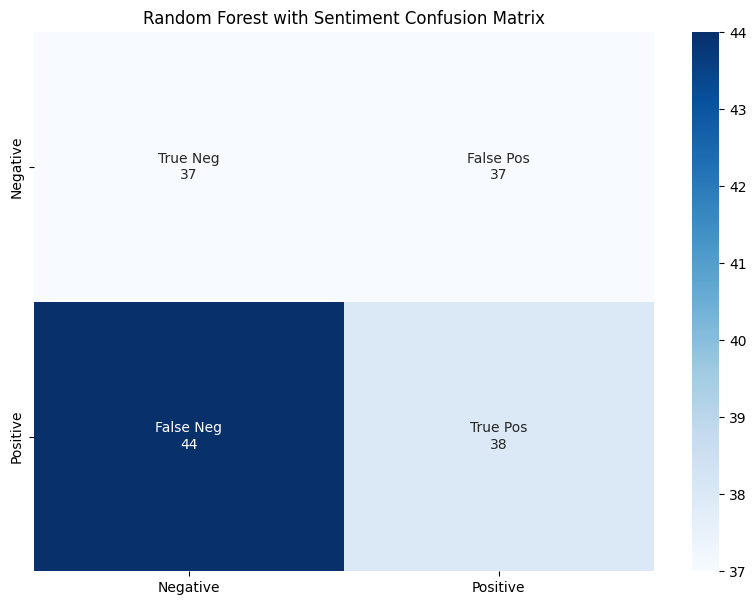

Best Model: RandomForestClassifier(max_depth=2, max_leaf_nodes=5, min_samples_split=5,
                       n_estimators=30, random_state=42)
Test Accuracy (after final fit): 0.4807692307692308


In [ ]:
def RF(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid):

    best_model = None
    best_score = 0
    best_k = None
    best_selected_features = None

    for k in k_values:
        select = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = select.fit_transform(X_train_scaled, y_train)
        X_test_selected = select.transform(X_test_scaled)

        tscv = TimeSeriesSplit(n_splits=5)
        rf = RandomForestClassifier(random_state=42)

        grid_search = GridSearchCV(rf, param_grid, cv=tscv)
        grid_search.fit(X_train_selected, y_train)

        y_test_pred = grid_search.best_estimator_.predict(X_test_selected)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        if test_accuracy > best_score:
            best_score = test_accuracy
            best_model = grid_search.best_estimator_
            best_k = k
            best_selected_features = feature_names[select.get_support()]

    print('Best k: ', best_k)
    print('Selected Features: ', best_selected_features)
    print('Best Test Accuracy: ', best_score)

    select = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = select.fit_transform(X_train_scaled, y_train)
    X_test_selected = select.transform(X_test_scaled)

    best_model.fit(X_train_selected, y_train)

    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Train Accuracy: ', train_accuracy)
    print('Test Accuracy (after final fit): ', test_accuracy)
    print('\nClassification Report on Test Set:')
    print(classification_report(y_test, y_test_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))

    y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc = round(roc_auc_score(y_test, y_test_pred_proba), 4)

    cm = confusion_matrix(y_test, y_test_pred)
    matrix_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    matrix_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(matrix_names, matrix_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Random Forest with Sentiment Confusion Matrix')
    plt.show()

    return best_model, fpr, tpr, auc, y_test, y_test_pred

k_values = list(range(1, 31))
param_grid = {
    'n_estimators': [30, 50],
    'max_depth': [2, 5, 8],
    'min_samples_split': [5, 8, 10],
    'max_leaf_nodes': [5]
}

best_model, fpr, tpr, auc, y_test, y_test_pred = RF(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid)
print('Best Model:', best_model)
print('Test Accuracy (after final fit):', accuracy_score(y_test, y_test_pred))


# RF without sentiment

In [ ]:
X_train.drop(columns=['Average Sentiment Score','encoded sentiment','sentiment 1D shift', 'sentiment 5D shift', 'sentiment 7D shift',
       'sentiment 10D shift', 'sentiment 14D shift', 'sentiment 30D shift',
       'Sentiment 5D Rolling Avg', 'Sentiment 10D Rolling Avg',
       'Sentiment 14D Rolling Avg', 'encoded sentiment 1D shift',
       'encoded sentiment 5D shift', 'enocded sentiment 7D shift',
       'encoded sentiment 10D shift', 'encoded sentiment 14D shift'], inplace = True)
X_test.drop(columns=['Average Sentiment Score','encoded sentiment','sentiment 1D shift', 'sentiment 5D shift', 'sentiment 7D shift',
       'sentiment 10D shift', 'sentiment 14D shift', 'sentiment 30D shift',
       'Sentiment 5D Rolling Avg', 'Sentiment 10D Rolling Avg',
       'Sentiment 14D Rolling Avg', 'encoded sentiment 1D shift',
       'encoded sentiment 5D shift', 'enocded sentiment 7D shift',
       'encoded sentiment 10D shift', 'encoded sentiment 14D shift'], inplace = True)

In [ ]:
# scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# extract the feature names - to be used later
feature_names = X_train.columns

Best k:  5
Selected Features:  Index(['high', 'close', 'change', 'daily variation', 'MACD'], dtype='object')
Best Test Accuracy:  0.5448717948717948
Train Accuracy:  0.6795580110497238
Test Accuracy (after final fit):  0.4166666666666667

Classification Report on Test Set:
              precision    recall  f1-score   support

        -1.0       0.36      0.30      0.33        74
         1.0       0.45      0.52      0.49        82

    accuracy                           0.42       156
   macro avg       0.41      0.41      0.41       156
weighted avg       0.41      0.42      0.41       156


Confusion Matrix:
[[22 52]
 [39 43]]


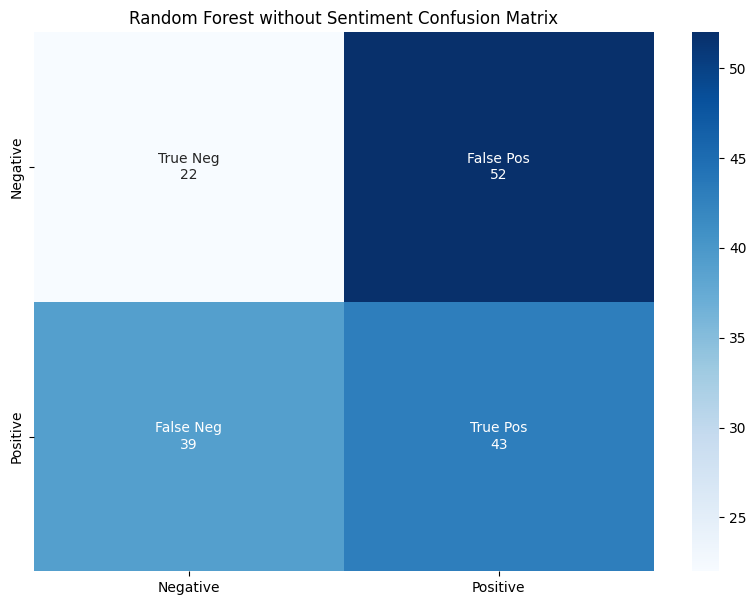

Best Model: RandomForestClassifier(max_depth=5, max_leaf_nodes=5, min_samples_split=5,
                       n_estimators=30, random_state=42)


In [ ]:
def RF(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid):

    best_model = None
    best_score = 0
    best_k = None
    best_selected_features = None

    for k in k_values:
        select = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = select.fit_transform(X_train_scaled, y_train)
        X_test_selected = select.transform(X_test_scaled)

        tscv = TimeSeriesSplit(n_splits=5)
        rf = RandomForestClassifier(random_state=42)

        grid_search = GridSearchCV(rf, param_grid, cv=tscv)
        grid_search.fit(X_train_selected, y_train)

        y_test_pred = grid_search.best_estimator_.predict(X_test_selected)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        if test_accuracy > best_score:
            best_score = test_accuracy
            best_model = grid_search.best_estimator_
            best_k = k
            best_selected_features = feature_names[select.get_support()]

    print('Best k: ', best_k)
    print('Selected Features: ', best_selected_features)
    print('Best Test Accuracy: ', best_score)

    select = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = select.fit_transform(X_train_scaled, y_train)
    X_test_selected = select.transform(X_test_scaled)

    best_model.fit(X_train_selected, y_train)

    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Train Accuracy: ', train_accuracy)
    print('Test Accuracy (after final fit): ', test_accuracy)
    print('\nClassification Report on Test Set:')
    print(classification_report(y_test, y_test_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))

    y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc = round(roc_auc_score(y_test, y_test_pred_proba), 4)

    cm = confusion_matrix(y_test, y_test_pred)
    matrix_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    matrix_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(matrix_names, matrix_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Random Forest without Sentiment Confusion Matrix')
    plt.show()

    return best_model, fpr, tpr, auc, y_test, y_test_pred


k_values = list(range(1, 19))
param_grid = {
    'n_estimators': [30, 50],
    'max_depth': [2, 5, 8],
    'min_samples_split': [5, 8, 10],
    'max_leaf_nodes': [5]
}

best_model1, fpr1, tpr1, auc1, y_test1, y_test_pred1 = RF(X_train_scaled, X_test_scaled, y_train, y_test, feature_names, k_values, param_grid)
print('Best Model:', best_model1)



# No sentment

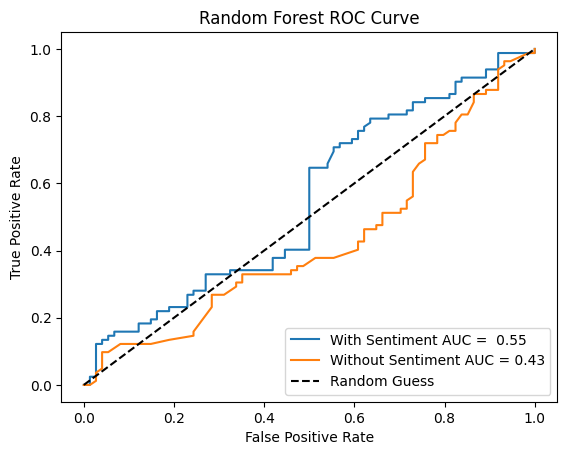

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label= f'With Sentiment AUC =  {auc:.2f}')
plt.plot(fpr1, tpr1, label=f'Without Sentiment AUC = {auc1:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()